# DAQC VQE Challenge – Using DAQC in Qiskit

Here, we provide an example of how to create an analog block with Qiskit. The most important part in the Qiskit documentation for this is the [HamiltonianGate](https://qiskit.org/documentation/stubs/qiskit.extensions.HamiltonianGate.html) class.

In [4]:
# In case you do not have numpy or qutip installed, you need to install it (of course, this is also true for qiskit)
!pip install numpy
!pip install qutip

     |████████████████████████████████| 16.1 MB 26 kB/s s eta 0:00:010:00:01


In [5]:
# We will need some functionality 
from typing import List 

# and from math related libraries
import numpy as np
import qutip as qt

# and from qiskit
from qiskit.extensions import HamiltonianGate
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Operator


## Creating a nearest neighbour Hamiltonian for a given connectivity

We now need a function that creates our Hamiltonian for a given connectivity

In [6]:
def create_zz_hamiltonian(num_qubits: int, connectivity: List[List[int]],
                              h_coeffs: List[float]) -> np.ndarray:
    """Creates a global Hamiltonian consisting of a sum of one (g * Z^i.Z^j) term per device connection.

    Args:
        num_qubits (int): number of qubits of the Hamiltonian
        connectivity (List[List[int]]): connectivity of the device
        h_coeffs (List[float]): list of coefficients of each ZZ term

    Returns:
        np.ndarray: tensored Hamiltonian
    """
    
    dim = 2 ** num_qubits
    num_connections = len(connectivity)
    zz_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)

    # create a matrix that is the sum of ZZ operators on all connected qubits,
    # tensored with the identity
    for c in range(num_connections):
        ops_to_tensor = [qt.identity(2)] * num_qubits
        ops_to_tensor[connectivity[c][0]] = qt.sigmaz()
        ops_to_tensor[connectivity[c][1]] = qt.sigmaz()
        zz_hamiltonian += h_coeffs[c] * np.array(qt.tensor(ops_to_tensor))

    return zz_hamiltonian

Now, we will actually create our Hamiltonian for a linear device: x--x--x--x
And use this Hamiltonian to create a analog block to be used within qiskit.

The HamiltonianGate implements a "gate" that is a unitary involving a number of qubits, that is equal to the unitary $U(t)$. The Hamiltonian stays constant, but $U(t)$ changes with time $t$. It specifies how long we leave our qubits interacting for. For an interval $t$ in between 0 and some time, the longer you leave it, the stronger the connection established is.

In [13]:
num_qubits = 4
hamiltonian = create_zz_hamiltonian(num_qubits, [[0, 1],[1,2],[2,3]], [1.,1.,1.,1.]) 
analog_block = HamiltonianGate(data=hamiltonian, time=2) 

## Building the circuit

Now we are all set to include this analog block into a circuit! As we are doing digital-analog quantum computing, we can of course also use digital single qubit gatesm. Let's see how this goes.

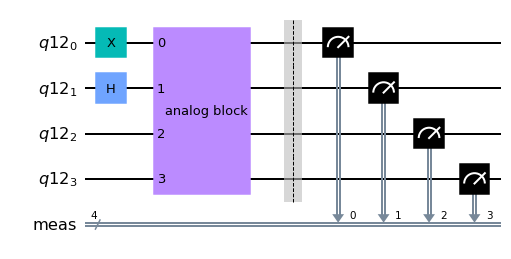

In [22]:
qr = QuantumRegister(num_qubits)
circ = QuantumCircuit(qr)

circ.x(0)
circ.h(1)
circ.unitary(analog_block, [qr[0], qr[1], qr[2], qr[3]], label='analog block')
circ.measure_all()

#As always, we can visualize our circuit using the `QuantumCircuit.draw()` method.
circ.draw()

The only thing left is that we also want to run our circuit:

In [23]:
simulator = Aer.get_backend('qasm_simulator') 
job = execute(circ, simulator, shots=1024) 

result = job.result()
counts = result.get_counts(circ)
print(counts)

#from qiskit.visualization import plot_histogram
#plot_histogram(counts)

{'0011': 505, '0001': 519}
